## Blackpink Member Classification


<h4>Import all the dependencies

In [1]:
import os
import cv2
import pywt
import shutil
import os.path
import matplotlib
import numpy as np
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

<h4>Data Gathering, Visualization and Cleaning

The data in this project are from Google images. I google image search each blackpink member and used <b>FatKun</b> chrome extention to batch download a total of 4,880 images. I created folders for each member containing their pictures. 

The raw dataset contains outliers such as images of non-blackpink members, their photos in side-view, etc. To clean the dataset, I used a function that detect faces in the image and will only return a cropped image as output if both eyes are detected in the picture. Lastly, the cropped images returned was stored in a folder and will be used for our model training.

In [2]:
jennie = cv2.imread('./test_images/jenniekim.jpg')
jennie.shape

(262, 192, 3)

In [3]:
gray = cv2.cvtColor(jennie, cv2.COLOR_BGR2GRAY)
gray

array([[ 40,  40,  40, ...,  42,  38,  36],
       [ 40,  40,  40, ...,  42,  38,  36],
       [ 40,  40,  40, ...,  42,  38,  36],
       ...,
       [ 47,  57,  65, ..., 217, 218, 218],
       [ 47,  54,  70, ..., 218, 218, 218],
       [ 46,  50,  74, ..., 218, 218, 217]], dtype=uint8)

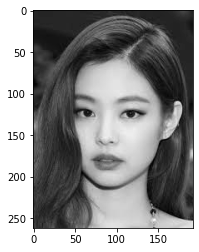

In [4]:
plt.imshow(gray, cmap='gray')

Loading haarcascades face and eye detector

In [5]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 26,  71, 138, 138]])

In [6]:
(x,y,w,h) = faces[0]
x,y,w,h

(26, 71, 138, 138)

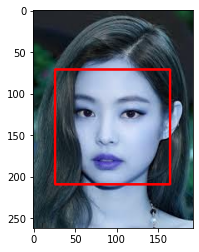

In [7]:
face_img = cv2.rectangle(jennie,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

In [8]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 7)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

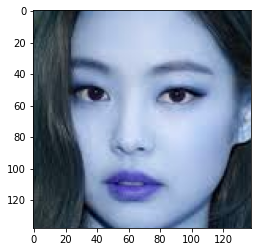

In [9]:
crop_image = get_cropped_image_if_2_eyes('./test_images/jenniekim.jpg')
plt.imshow(crop_image, cmap='gray')

In [10]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"
img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [11]:
img_dirs

['./dataset/jennie_kim',
 './dataset/jisoo_kim',
 './dataset/lisa_manoban',
 './dataset/rose_park']

In [12]:
cropped_image_dirs = []
bpmember_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    member_name = img_dir.split('/')[-1]
    
    bpmember_file_names_dict[member_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + member_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            
            cropped_file_name = member_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            bpmember_file_names_dict[member_name].append(cropped_file_path)
            count+=1

Generating cropped images in folder:  ./dataset/cropped/jennie_kim
Generating cropped images in folder:  ./dataset/cropped/jisoo_kim
Generating cropped images in folder:  ./dataset/cropped/lisa_manoban
Generating cropped images in folder:  ./dataset/cropped/rose_park


<h4>After generating the cropped images, I manually clean the dataset by removing non-blackpink members and faces that are not belong in their proper class (E.g. Image of Jisoo in Lisa's folder) before running the rest of the code below.

In [13]:
img_cr_dirs= []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        img_cr_dirs.append(entry.path)
img_cr_dirs

['./dataset/cropped/jennie_kim',
 './dataset/cropped/jisoo_kim',
 './dataset/cropped/lisa_manoban',
 './dataset/cropped/rose_park']

In [14]:
bpmember_file_names_dict = {}
for img_dir in img_cr_dirs:
    member_name = img_dir.split('/')[-1]
    bpmember_file_names_dict[member_name] = []
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    bpmember_file_names_dict[member_name] = file_list
bpmember_file_names_dict

{'jennie_kim': ['./dataset/cropped/jennie_kim\\jennie_kim1.png',
  './dataset/cropped/jennie_kim\\jennie_kim10.png',
  './dataset/cropped/jennie_kim\\jennie_kim101.png',
  './dataset/cropped/jennie_kim\\jennie_kim103.png',
  './dataset/cropped/jennie_kim\\jennie_kim104.png',
  './dataset/cropped/jennie_kim\\jennie_kim105.png',
  './dataset/cropped/jennie_kim\\jennie_kim106.png',
  './dataset/cropped/jennie_kim\\jennie_kim107.png',
  './dataset/cropped/jennie_kim\\jennie_kim108.png',
  './dataset/cropped/jennie_kim\\jennie_kim109.png',
  './dataset/cropped/jennie_kim\\jennie_kim11.png',
  './dataset/cropped/jennie_kim\\jennie_kim110.png',
  './dataset/cropped/jennie_kim\\jennie_kim111.png',
  './dataset/cropped/jennie_kim\\jennie_kim113.png',
  './dataset/cropped/jennie_kim\\jennie_kim114.png',
  './dataset/cropped/jennie_kim\\jennie_kim115.png',
  './dataset/cropped/jennie_kim\\jennie_kim116.png',
  './dataset/cropped/jennie_kim\\jennie_kim117.png',
  './dataset/cropped/jennie_kim\\jen

In [15]:
class_dict = {}
count = 0

for member_name in bpmember_file_names_dict.keys():
    class_dict[member_name] = count
    count = count + 1
class_dict

{'jennie_kim': 0, 'jisoo_kim': 1, 'lisa_manoban': 2, 'rose_park': 3}

In [16]:
X, y = [], []
for member_name, training_files in bpmember_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        img_reshaped = cv2.resize(img, (180,180))
        X.append(img_reshaped)
        y.append(class_dict[member_name])

In [17]:
#Converting to numpy array
X = np.array(X).astype(float)
y = np.array(y)

In [18]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

<h4>Building the model using Convolutional Neural Network

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                      input_shape=(180,180,3)),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomRotation(0.1)    
])

In [21]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

model.build(input_shape=(180,180,3))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 179, 179, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)       

In [23]:
EPOCHS = 600
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    X_train_scaled,
    y_train,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/600
33/33 [==============================] - 2s 62ms/step - loss: 1.3822 - accuracy: 0.3090
Epoch 2/600
33/33 [==============================] - 1s 38ms/step - loss: 1.3644 - accuracy: 0.3205
Epoch 3/600
33/33 [==============================] - 2s 54ms/step - loss: 1.2620 - accuracy: 0.3935
Epoch 4/600
33/33 [==============================] - 1s 38ms/step - loss: 1.1206 - accuracy: 0.4827
Epoch 5/600
33/33 [==============================] - 2s 56ms/step - loss: 1.0760 - accuracy: 0.4952
Epoch 6/600
33/33 [==============================] - 1s 41ms/step - loss: 1.0132 - accuracy: 0.5259
Epoch 7/600
33/33 [==============================] - 1s 40ms/step - loss: 0.9925 - accuracy: 0.5777
Epoch 8/600
33/33 [==============================] - 1s 39ms/step - loss: 0.9512 - accuracy: 0.5662
Epoch 9/600
33/33 [==============================] - 1s 39ms/step - loss: 0.9963 - accuracy: 0.5547
Epoch 10/600
33/33 [==============================] - 1s 39ms/step - loss: 0.9497 - accuracy: 0.5835

33/33 [==============================] - 1s 40ms/step - loss: 0.4459 - accuracy: 0.8407
Epoch 83/600
33/33 [==============================] - 2s 54ms/step - loss: 0.4011 - accuracy: 0.8647
Epoch 84/600
33/33 [==============================] - 1s 38ms/step - loss: 0.4281 - accuracy: 0.8503
Epoch 85/600
33/33 [==============================] - 1s 40ms/step - loss: 0.4331 - accuracy: 0.8369
Epoch 86/600
33/33 [==============================] - 2s 46ms/step - loss: 0.3683 - accuracy: 0.8570
Epoch 87/600
33/33 [==============================] - 1s 41ms/step - loss: 0.4275 - accuracy: 0.8282
Epoch 88/600
33/33 [==============================] - 1s 40ms/step - loss: 0.3919 - accuracy: 0.8570
Epoch 89/600
33/33 [==============================] - 1s 41ms/step - loss: 0.3731 - accuracy: 0.8618
Epoch 90/600
33/33 [==============================] - 1s 39ms/step - loss: 0.4298 - accuracy: 0.8445
Epoch 91/600
33/33 [==============================] - 1s 39ms/step - loss: 0.3734 - accuracy: 0.8560
Epo

33/33 [==============================] - 1s 41ms/step - loss: 0.2327 - accuracy: 0.9223
Epoch 163/600
33/33 [==============================] - 1s 39ms/step - loss: 0.2426 - accuracy: 0.9079
Epoch 164/600
33/33 [==============================] - 1s 39ms/step - loss: 0.2495 - accuracy: 0.9050
Epoch 165/600
33/33 [==============================] - 1s 40ms/step - loss: 0.2741 - accuracy: 0.8935
Epoch 166/600
33/33 [==============================] - 2s 57ms/step - loss: 0.2327 - accuracy: 0.9155
Epoch 167/600
33/33 [==============================] - 1s 41ms/step - loss: 0.2414 - accuracy: 0.9184
Epoch 168/600
33/33 [==============================] - 1s 37ms/step - loss: 0.2264 - accuracy: 0.9088
Epoch 169/600
33/33 [==============================] - 1s 36ms/step - loss: 0.2417 - accuracy: 0.9155
Epoch 170/600
33/33 [==============================] - 1s 36ms/step - loss: 0.2072 - accuracy: 0.9357
Epoch 171/600
33/33 [==============================] - 1s 36ms/step - loss: 0.2401 - accuracy: 0

33/33 [==============================] - 1s 36ms/step - loss: 0.1495 - accuracy: 0.9491
Epoch 243/600
33/33 [==============================] - 1s 36ms/step - loss: 0.2029 - accuracy: 0.9271
Epoch 244/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1740 - accuracy: 0.9347
Epoch 245/600
33/33 [==============================] - 1s 41ms/step - loss: 0.1587 - accuracy: 0.9386
Epoch 246/600
33/33 [==============================] - 1s 40ms/step - loss: 0.1519 - accuracy: 0.9405
Epoch 247/600
33/33 [==============================] - 1s 41ms/step - loss: 0.1859 - accuracy: 0.9232
Epoch 248/600
33/33 [==============================] - 1s 41ms/step - loss: 0.1779 - accuracy: 0.9347
Epoch 249/600
33/33 [==============================] - 1s 37ms/step - loss: 0.1673 - accuracy: 0.9443
Epoch 250/600
33/33 [==============================] - 1s 37ms/step - loss: 0.1624 - accuracy: 0.9415
Epoch 251/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1763 - accuracy: 0

33/33 [==============================] - 1s 39ms/step - loss: 0.0968 - accuracy: 0.9635
Epoch 323/600
33/33 [==============================] - 1s 39ms/step - loss: 0.1116 - accuracy: 0.9635
Epoch 324/600
33/33 [==============================] - 1s 41ms/step - loss: 0.1083 - accuracy: 0.9587
Epoch 325/600
33/33 [==============================] - 1s 41ms/step - loss: 0.1415 - accuracy: 0.9578
Epoch 326/600
33/33 [==============================] - 1s 45ms/step - loss: 0.1484 - accuracy: 0.9463
Epoch 327/600
33/33 [==============================] - 1s 44ms/step - loss: 0.1706 - accuracy: 0.9443
Epoch 328/600
33/33 [==============================] - 1s 42ms/step - loss: 0.1219 - accuracy: 0.9539
Epoch 329/600
33/33 [==============================] - 1s 44ms/step - loss: 0.1353 - accuracy: 0.9501
Epoch 330/600
33/33 [==============================] - 1s 43ms/step - loss: 0.1316 - accuracy: 0.9530
Epoch 331/600
33/33 [==============================] - 1s 42ms/step - loss: 0.1194 - accuracy: 0

33/33 [==============================] - 2s 54ms/step - loss: 0.0988 - accuracy: 0.9693
Epoch 403/600
33/33 [==============================] - 1s 37ms/step - loss: 0.1185 - accuracy: 0.9616
Epoch 404/600
33/33 [==============================] - 1s 39ms/step - loss: 0.1290 - accuracy: 0.9587
Epoch 405/600
33/33 [==============================] - 1s 39ms/step - loss: 0.1189 - accuracy: 0.9568
Epoch 406/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1115 - accuracy: 0.9607
Epoch 407/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1021 - accuracy: 0.9616
Epoch 408/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1559 - accuracy: 0.9424
Epoch 409/600
33/33 [==============================] - 1s 44ms/step - loss: 0.1059 - accuracy: 0.9597
Epoch 410/600
33/33 [==============================] - 2s 58ms/step - loss: 0.0918 - accuracy: 0.9635
Epoch 411/600
33/33 [==============================] - 2s 48ms/step - loss: 0.1066 - accuracy: 0

33/33 [==============================] - 1s 37ms/step - loss: 0.0997 - accuracy: 0.9616
Epoch 483/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1161 - accuracy: 0.9568
Epoch 484/600
33/33 [==============================] - 1s 37ms/step - loss: 0.1176 - accuracy: 0.9559
Epoch 485/600
33/33 [==============================] - 2s 58ms/step - loss: 0.1178 - accuracy: 0.9597
Epoch 486/600
33/33 [==============================] - 2s 48ms/step - loss: 0.1012 - accuracy: 0.9664
Epoch 487/600
33/33 [==============================] - 2s 49ms/step - loss: 0.0840 - accuracy: 0.9693
Epoch 488/600
33/33 [==============================] - 2s 49ms/step - loss: 0.1302 - accuracy: 0.9607
Epoch 489/600
33/33 [==============================] - 2s 53ms/step - loss: 0.0888 - accuracy: 0.9712
Epoch 490/600
33/33 [==============================] - 2s 50ms/step - loss: 0.0757 - accuracy: 0.9722
Epoch 491/600
33/33 [==============================] - 2s 51ms/step - loss: 0.0826 - accuracy: 0

33/33 [==============================] - 1s 38ms/step - loss: 0.0755 - accuracy: 0.9770
Epoch 563/600
33/33 [==============================] - 1s 40ms/step - loss: 0.0600 - accuracy: 0.9779
Epoch 564/600
33/33 [==============================] - 1s 40ms/step - loss: 0.0801 - accuracy: 0.9693
Epoch 565/600
33/33 [==============================] - 1s 37ms/step - loss: 0.0645 - accuracy: 0.9712
Epoch 566/600
33/33 [==============================] - 1s 41ms/step - loss: 0.0744 - accuracy: 0.9655
Epoch 567/600
33/33 [==============================] - 1s 37ms/step - loss: 0.0670 - accuracy: 0.9770
Epoch 568/600
33/33 [==============================] - 1s 38ms/step - loss: 0.1205 - accuracy: 0.9597
Epoch 569/600
33/33 [==============================] - 1s 37ms/step - loss: 0.0878 - accuracy: 0.9722
Epoch 570/600
33/33 [==============================] - 2s 54ms/step - loss: 0.0781 - accuracy: 0.9702
Epoch 571/600
33/33 [==============================] - 2s 54ms/step - loss: 0.0840 - accuracy: 0

<h4>Model Scores and Prediction

In [25]:
scores = model.evaluate(X_test_scaled, y_test)

4/4 [==============================] - 0s 40ms/step - loss: 0.5840 - accuracy: 0.9224


In [26]:
predictions = model.predict(X_test_scaled)

In [27]:
y_classes = [np.argmax(element) for element in predictions]

In [28]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_classes)

Text(69.0, 0.5, 'Truth')

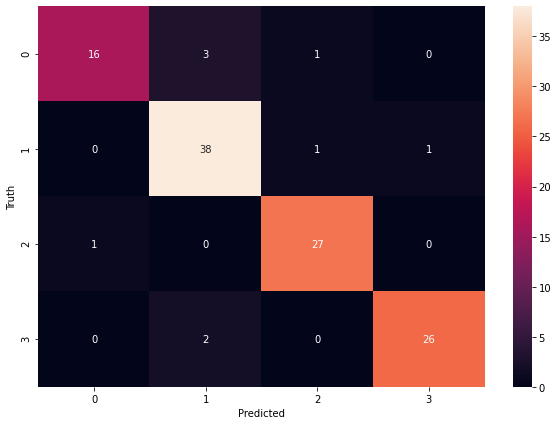

In [29]:
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
from sklearn.metrics import confusion_matrix , classification_report

print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.88      0.95      0.92        40
           2       0.93      0.96      0.95        28
           3       0.96      0.93      0.95        28

    accuracy                           0.92       116
   macro avg       0.93      0.91      0.92       116
weighted avg       0.92      0.92      0.92       116



In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

<h4>Graphs showing the training accuracy and loss of the model

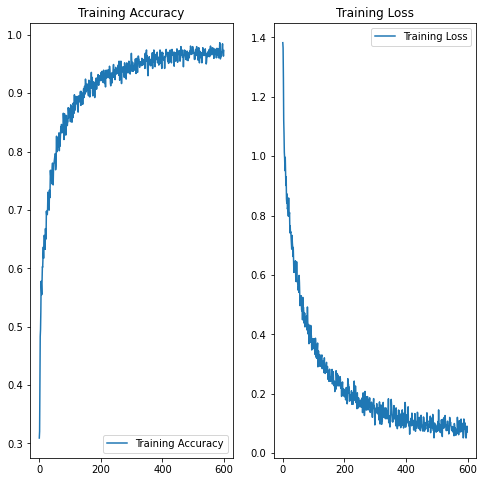

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

#### Saving the model

In [34]:
model.save('./model/bp_cnn.h5')